In [1]:
# core
import time
import sys
from concurrent.futures import ProcessPoolExecutor

# custom
sys.path.append('../code')
import data_processing as dp
import short_squeeze_eda as sse
from utils import get_home_dir
HOME_DIR = get_home_dir(repo_name='scrape_stocks')

# installed
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Scatter, Scattergl, Figure, Layout
init_notebook_mode()
import seaborn as sns

/usr/local/lib/python3.5/dist-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [2]:
short_stocks = sse.get_stocks()
dfs, sh_int, fin_sh = dp.load_stocks(stocks=short_stocks,
                                     short_interest=True, 
                                     TAfunc='create_varied_tas',
                                     calc_scores=False)

loading stocks...
calculating TAs...
getting finra shorts and merging...
getting short interest and merging...


In [3]:
def get_iq_limits(sr, iq_range=0.5):
    """
    returns borders of interquartile range for using with .clip()
    """
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    return qlow, qhigh

In [4]:
def get_fut_pct_change(df, days=10):
    """
    takes a dataframe and gets the price change in the future 'days' from now
    """
    # (future - current) / current, pad end with nans
    future = df['typical_price'].iloc[days:].values
    current = df['typical_price'].iloc[:-days].values
    df['tp_' + str(days) + 'd_diff'] = np.hstack(((future - current) / current, np.array([np.nan] * days)))

In [5]:
# make future price targets
for s in sh_int.keys():
    # skip dataframes that are too small
    if sh_int[s].shape[0] <=40:
        continue
        
    for i in [10, 20, 40]:
        get_fut_pct_change(sh_int[s], days=i)

In [6]:
# columns with range 0-100
range_cols = ['Short_%_of_Float',
             '%_Insider_Ownership',
             '%_Institutional_Ownership']

range_cols = range_cols + ['rsi_tp_' + str(i) for i in range(10, 201, 20)]
range_cols = range_cols + ['mdi_' + str(i) for i in range(10, 201, 20)]

# range -100 to 100
range_cols = range_cols + ['cmo_tp_' + str(i) for i in range(10, 201, 20)]
range_cols = range_cols + ['apo_tp_slow=' + str(i) for i in range(10, 201, 20)]

In [7]:
full_sh_df = pd.concat([sh_int[s] for s in sh_int.keys()])

In [8]:
full_sh_df_clip = full_sh_df.copy()
for c in full_sh_df.columns:
    if c not in range_cols:
        if 'd_diff' in c:
            lo = -0.4
            hi = 0.4
        else:
            lo, hi = get_iq_limits(full_sh_df[c], iq_range=0.96)
            
        full_sh_df_clip[c] = full_sh_df[c].clip(lower=lo, upper=hi)
    else:
        full_sh_df_clip[c] = full_sh_df[c]

In [9]:
list(full_sh_df_clip.columns)

['%_Change_Mo/Mo',
 '%_Insider_Ownership',
 '%_Institutional_Ownership',
 '%_from_200_day_MA',
 '%_from_50_day_MA',
 '%_from_52-wk_High',
 'Adj_Close',
 'Adj_High',
 'Adj_Low',
 'Adj_Open',
 'Adj_Volume',
 'Avg._Daily_Vol.',
 'Close',
 'Days_to_Cover',
 'Dividend',
 'High',
 'Low',
 'Open',
 'Performance_(52-wk)',
 'Shares_Float',
 'Shares_Outstanding',
 'Short_%_of_Float',
 'Short_Prior_Mo',
 'Short_Squeeze_Ranking',
 'Split',
 'Total_Short_Interest',
 'Volume',
 'apo_tp_slow=10',
 'apo_tp_slow=110',
 'apo_tp_slow=130',
 'apo_tp_slow=150',
 'apo_tp_slow=170',
 'apo_tp_slow=190',
 'apo_tp_slow=30',
 'apo_tp_slow=50',
 'apo_tp_slow=70',
 'apo_tp_slow=90',
 'bband_u_tp_diff_10',
 'bband_u_tp_diff_110',
 'bband_u_tp_diff_130',
 'bband_u_tp_diff_150',
 'bband_u_tp_diff_170',
 'bband_u_tp_diff_190',
 'bband_u_tp_diff_30',
 'bband_u_tp_diff_50',
 'bband_u_tp_diff_70',
 'bband_u_tp_diff_90',
 'bband_u_tp_diff_hi_10',
 'bband_u_tp_diff_hi_110',
 'bband_u_tp_diff_hi_130',
 'bband_u_tp_diff_hi_1

In [10]:
# columns to ignore because they have large outliers that can't really be ignored
ignore_cols = set(['Open',
                    'Close',
                    'Low', 
                    'High',
                    'Volume',
                    'Adj_Open',
                    'Adj_Close',
                    'Adj_Low',
                    'Adj_High',
                    'Adj_Volume',
                    'typical_price',
                    'Dividend',
                    'Split',
                    'bband_u_cl',
                    'bband_m_cl',
                    'bband_l_cl',
                    'bband_u_tp',
                    'bband_m_tp',
                    'bband_l_tp',
                    'dema_cl',
                    'dema_tp',
                    'ema_cl',
                    'ema_tp',
                    'ht_tl_cl',
                    'ht_tl_tp',
                    'kama_cl',
                    'kama_tp',
                    'mavp_cl',
                    'mavp_tp',
                    'midp_cl',
                    'midp_tp',
                    'midpr',
                    'sar',
                    'sma_10_cl',
                    'sma_10_tp',
                    'sma_20_cl',
                    'sma_20_tp',
                    'sma_30_cl',
                    'sma_30_tp',
                    'sma_40_cl',
                    'sma_40_tp',
                    'tema_cl',
                    'tema_tp',
                    'trima_cl',
                    'trima_tp',
                    'wma_cl',
                    'wma_tp',
                    'mdm',
                    'pldm',
                    'rocr_cl_100', # already have the same data /100 as rocr
                    'rocr_tp_100',
                    'atr',
                    'natr',
                    'trange',
                    'Shares_Float',
                    'Shares_Outstanding',
                    'Avg._Daily_Vol.'])

keep_cols = [c for c in full_sh_df.columns if c not in ignore_cols]

In [11]:
full_sh_df_clip_abbrev = full_sh_df_clip[keep_cols]

In [12]:
full_corr = full_sh_df_clip_abbrev.corr()

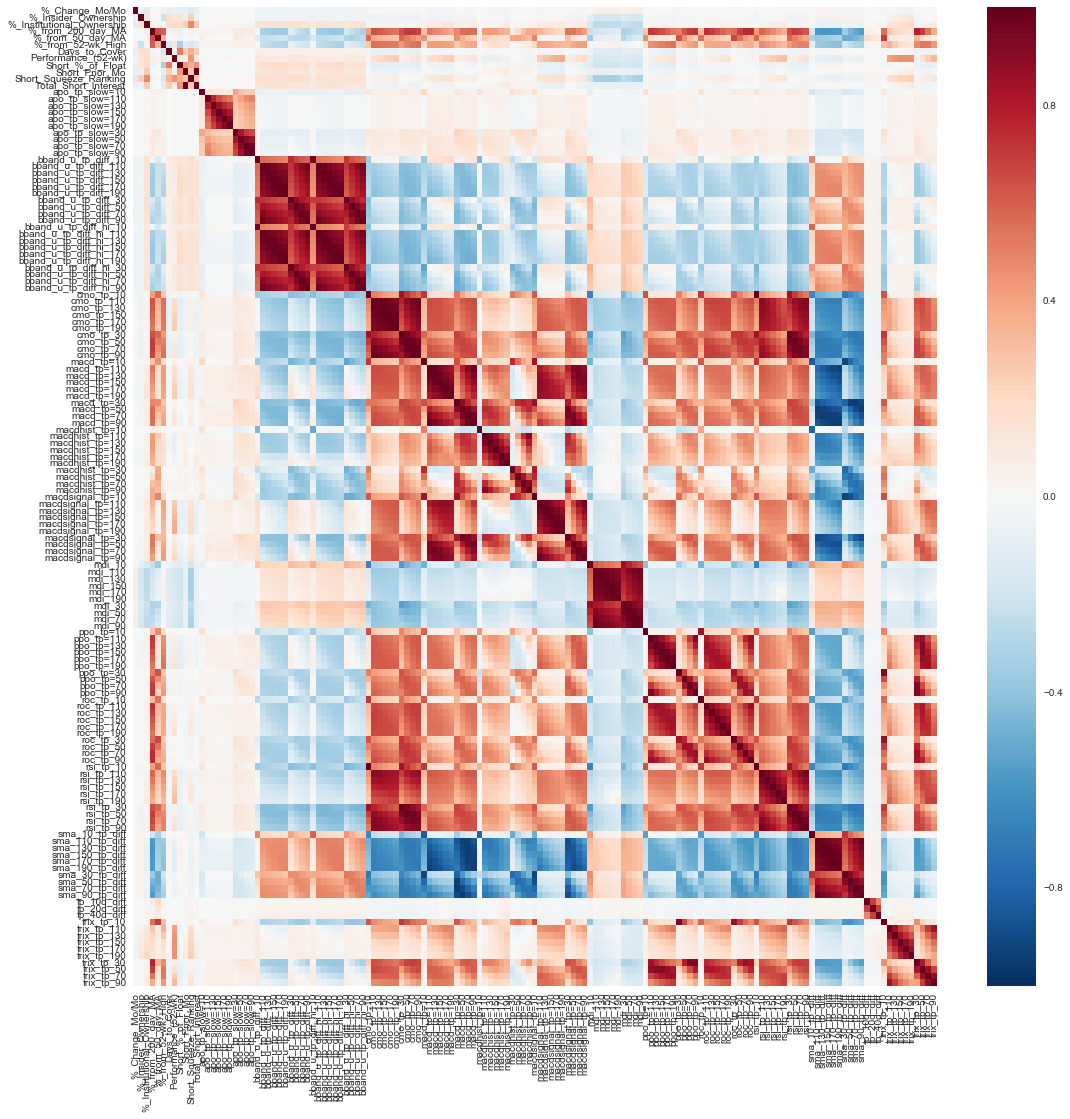

In [13]:
f = plt.figure(figsize=(18, 18))
_ = sns.heatmap(full_corr)

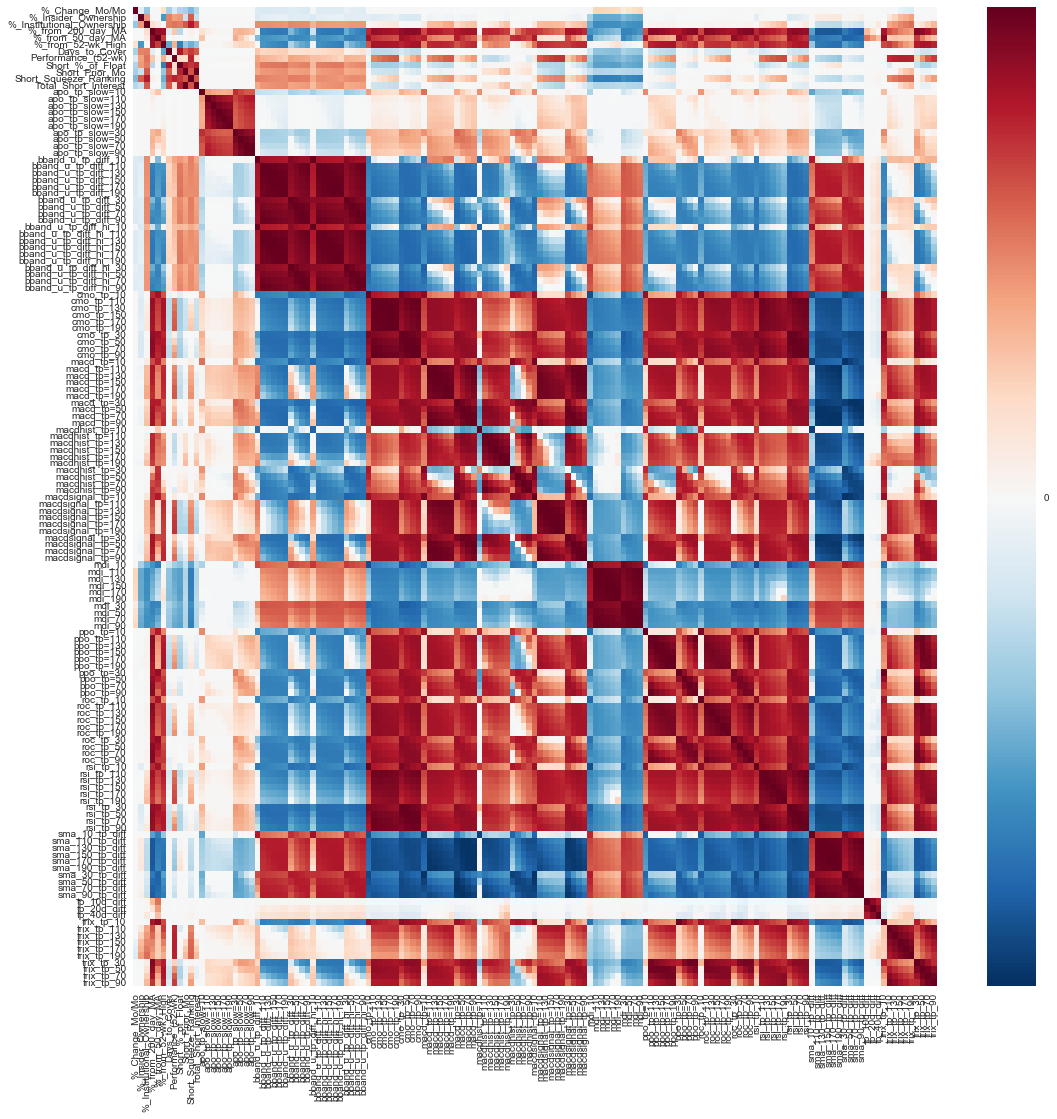

In [14]:
from matplotlib.colors import SymLogNorm
f = plt.figure(figsize=(18, 18))
_ = sns.heatmap(full_corr, norm=SymLogNorm(linthresh=0.03, linscale=0.03, vmin=full_corr.min(), vmax=full_corr.max()))

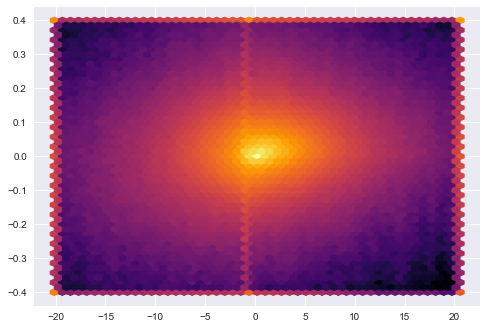

In [15]:
_ = plt.hexbin(full_sh_df_clip_abbrev['%_from_50_day_MA'],
               full_sh_df_clip_abbrev['tp_40d_diff'],
               gridsize=50,
               cmap='inferno',
               bins='log')

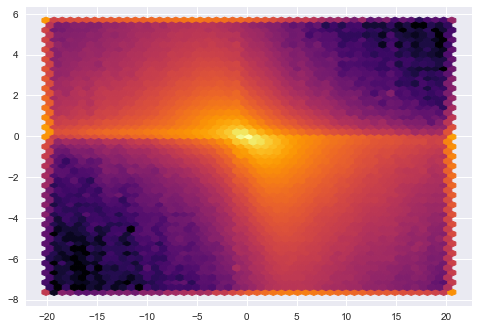

In [16]:
_ = plt.hexbin(full_sh_df_clip_abbrev['%_from_50_day_MA'],
               full_sh_df_clip_abbrev['sma_50_tp_diff'],
               gridsize=50,
               cmap='inferno',
               bins='log')